# 빅데이터와 금융자료분석 팀프로젝트

XGboost 알고리즘을 활용한 은행 대출의 부도 여부 예측 모델 구축

강상묵(20259013) / 김형환(20249132) / 유석호(20249264) / 이현준(20249349) / 최영서(20249430) / 최재필(20249433)

In [1]:
# 필요 라이브러리 모음
import os
import random
import pickle
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from boruta import BorutaPy
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import IsolationForest, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import ADASYN
from IPython.display import Image, display

In [2]:
# 모든 난수 생성기에 일관된 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# 결과 저장을 위한 디렉토리 생성
os.makedirs('model_results', exist_ok=True)
os.makedirs('plots', exist_ok=True)  # plots 디렉토리 생성

## 1. 데이터 불러오기 및 데이터 확인
12개의 수치형변수와 15개의 문자형 변수(목적변수 포함)

In [3]:
# 1. 데이터 불러오기 및 데이터 확인 : 12개의 수치형변수와 15개의 문자형 변수(목적변수 포함)
data = pd.read_csv("data/lending_club_loan_two.csv")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

### 클래스 불균형 및 변수간 상관관계 시각화

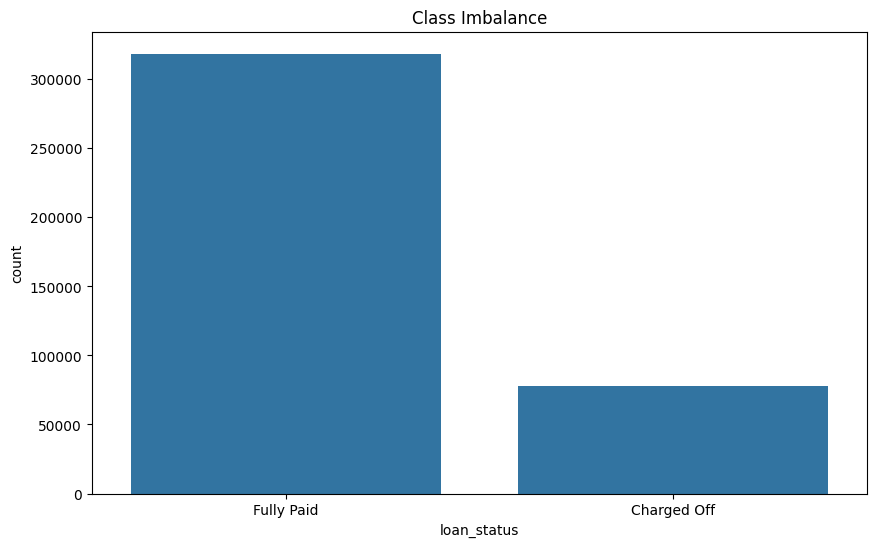

In [4]:
# 클래스 불균형 시각화 : 목적변수는 약 8:2로 불균형 존재
plt.figure(figsize=(10, 6))
sns.countplot(x=data['loan_status'])
plt.title("Class Imbalance")
plt.savefig('plots/class_imbalance.png', bbox_inches='tight', dpi=300)

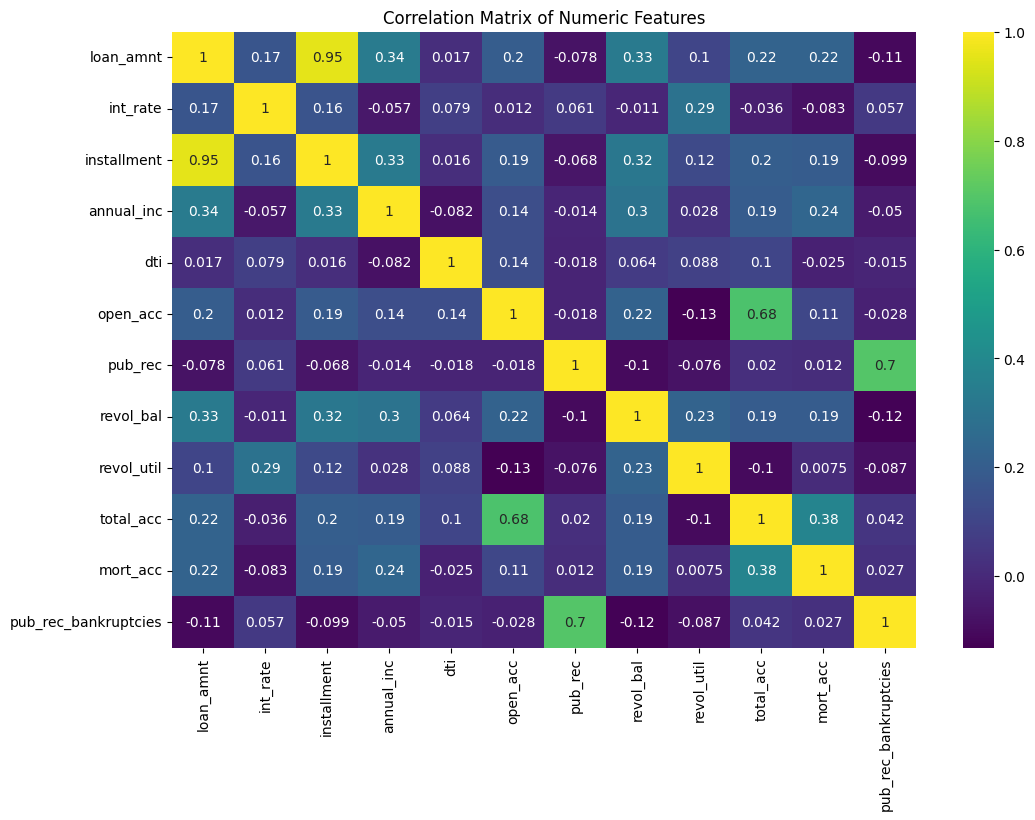

In [5]:
# 수치형 데이터간 상관관계 행렬 그리기 : 일부 변수에 높은 상관관계가 존재하는 것을 확인
plt.figure(figsize=(12, 8))

numeric_data = data.select_dtypes(include=['number'])

sns.heatmap(numeric_data.corr(), annot=True, cmap='viridis')
plt.title("Correlation Matrix of Numeric Features")
plt.savefig('plots/correlation_matrix.png', bbox_inches='tight', dpi=300)

### 주요 변수별 목적변수 분포 확인

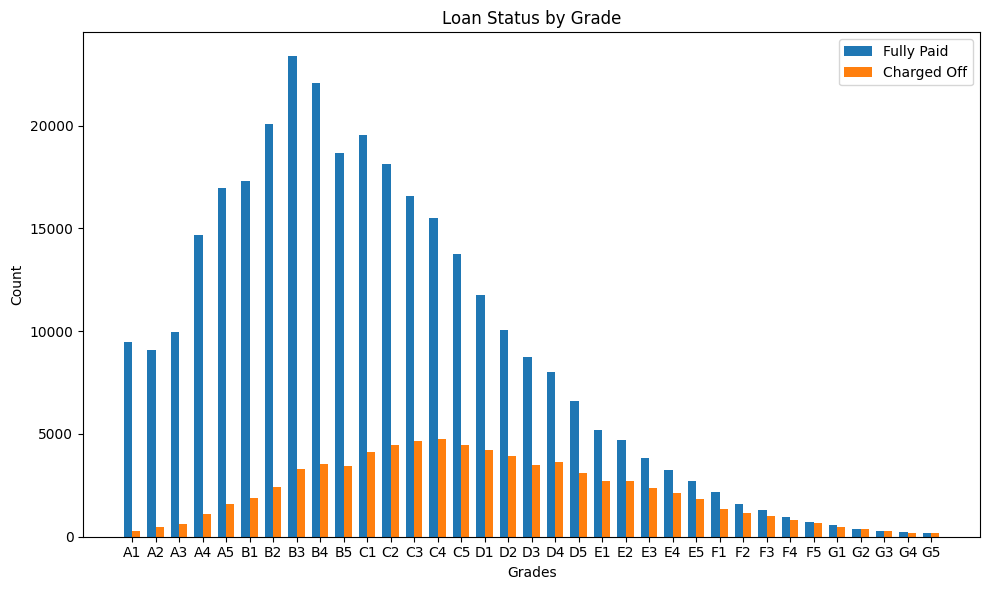

In [6]:
# 신용점수별 목적변수의 분포 확인 : 낮은 등급일수록 부도율 높음
fully_paid = data.loc[data['loan_status'] == 'Fully Paid', 'sub_grade'].value_counts().sort_index()
charged_off = data.loc[data['loan_status'] == 'Charged Off', 'sub_grade'].value_counts().sort_index()

grades = sorted(set(fully_paid.index).union(set(charged_off.index)))

x = range(len(grades))
width = 0.35  # bar 폭

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar([i - width/2 for i in x], fully_paid.reindex(grades, fill_value=0), width=width, label='Fully Paid')
ax.bar([i + width/2 for i in x], charged_off.reindex(grades, fill_value=0), width=width, label='Charged Off')

ax.set_xlabel('Grades')
ax.set_ylabel('Count')
ax.set_title('Loan Status by Grade')
ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.legend()
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('plots/loan_status_by_grade.png', bbox_inches='tight', dpi=300)

/var/folders/n2/jbh_0_091bx8qgz7j87t2qwc0000gp/T/ipykernel_10403/1900938984.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


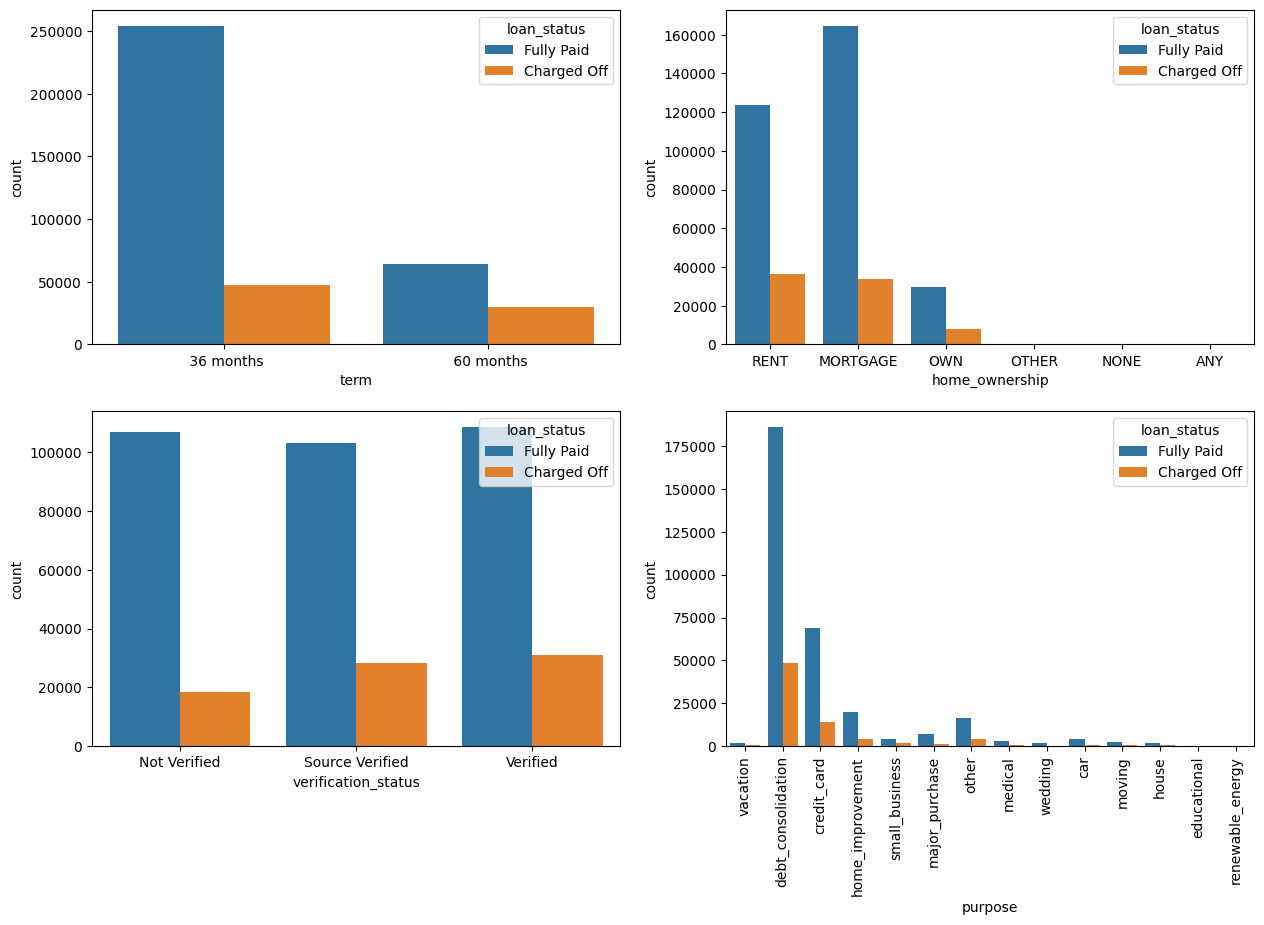

In [7]:
# 대출기간, 집보유여부 등 주요 변수에 대한 목적변수 분포 확인
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plt.savefig('plots/loan_status_by_features.png', bbox_inches='tight', dpi=300)

In [8]:
# 문자형 변수 고유값 개수 출력 : 일부 변수에 과도하게 많은 고유값 확인
categorical_columns = data.select_dtypes(include='object')
categorical_columns.nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              173105
emp_length                 11
home_ownership              6
verification_status         3
issue_d                   115
loan_status                 2
purpose                    14
title                   48816
earliest_cr_line          684
initial_list_status         2
application_type            3
address                393700
dtype: int64

## 2. 데이터 전처리

### 변수를 분석에 적합하도록 변환, 삭제 등 처리

In [9]:
# 2. 데이터 전처리
# 주소는 우편번호만 추출
data['zip_code'] = data.address.apply(lambda x: x[-5:])
data['zip_code'].nunique()

10

In [10]:
# 집 소유여부에서 극소수의 경우 제외
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  

# 대출건별로 모두 달라 고유값이 너무 많거나(100개 이상), 다른 변수로부터 추출할수있는 등 불필요한 열 제거
drop_cols = ['emp_title', 'emp_length', 'grade', 'title', 'address', 'issue_d', 'earliest_cr_line']
data.drop(columns=drop_cols, inplace=True)

# 대출개월수는 수치형으로 변환
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

# 문자형변수 변환 : 라벨인코딩, 원핫인코딩
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 목적변수 (loan_status) 라벨 인코딩
label_encoder = LabelEncoder()
data['loan_status'] = label_encoder.fit_transform(data['loan_status'])

# sub_grade 라벨 인코딩 : 평가등급은 순서가 있음
data['sub_grade'] = label_encoder.fit_transform(data['sub_grade'])

# 나머지 문자형 변수들 원핫 인코딩
categorical_columns = data.select_dtypes(include='object').columns
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 45 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            396030 non-null  float64
 1   term                                 396030 non-null  int64  
 2   int_rate                             396030 non-null  float64
 3   installment                          396030 non-null  float64
 4   sub_grade                            396030 non-null  int64  
 5   annual_inc                           396030 non-null  float64
 6   loan_status                          396030 non-null  int64  
 7   dti                                  396030 non-null  float64
 8   open_acc                             396030 non-null  float64
 9   pub_rec                              396030 non-null  float64
 10  revol_bal                            396030 non-null  float64
 11  revol_util   

### 훈련/평가데이터 분할

목적변수의 불균형이 존재하므로, 분할 시 **계층적 샘플링(Stratified Sampling)**을 적용

이는 각 분할 세트에서 클래스 비율이 원본 데이터셋과 동일하게 유지되도록 보장

In [11]:
# 훈련/평가데이터 분할 : 7대3로 분할 (계층적 샘플링 적용)
X = data.drop(columns=['loan_status']) 
y = data['loan_status']

# stratify=y 매개변수를 추가하여 계층적 샘플링 적용
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 분할 후 클래스 비율 확인
print("원본 데이터 클래스 분포:")
print(y.value_counts(normalize=True))

print("\n훈련 데이터 클래스 분포:")
print(y_train.value_counts(normalize=True))

print("\n테스트 데이터 클래스 분포:")
print(y_test.value_counts(normalize=True))

원본 데이터 클래스 분포:
loan_status
1    0.803871
0    0.196129
Name: proportion, dtype: float64

훈련 데이터 클래스 분포:
loan_status
1    0.803871
0    0.196129
Name: proportion, dtype: float64

테스트 데이터 클래스 분포:
loan_status
1    0.80387
0    0.19613
Name: proportion, dtype: float64


### 결측치 및 이상치 처리

In [12]:
# 3. 결측값 및 이상치 처리 (중간값 + Isolation Forest)
# 수치형 변수의 결측값을 중간값으로 처리
X_train_fillna = X_train.copy().fillna(X_train.median())

X_train_numeric = X_train_fillna.select_dtypes(include='number')
original_len = len(X_train_numeric)

# 이상치 탐지 및 제거 (수치형 변수에 대해서만 1% 제거)
iso = IsolationForest(contamination=0.01, random_state=42)
outliers = iso.fit_predict(X_train_numeric)

# 이상치가 아닌 데이터만 선택
X_train_clean = X_train_fillna[outliers == 1]
y_train_clean = y_train[outliers == 1]

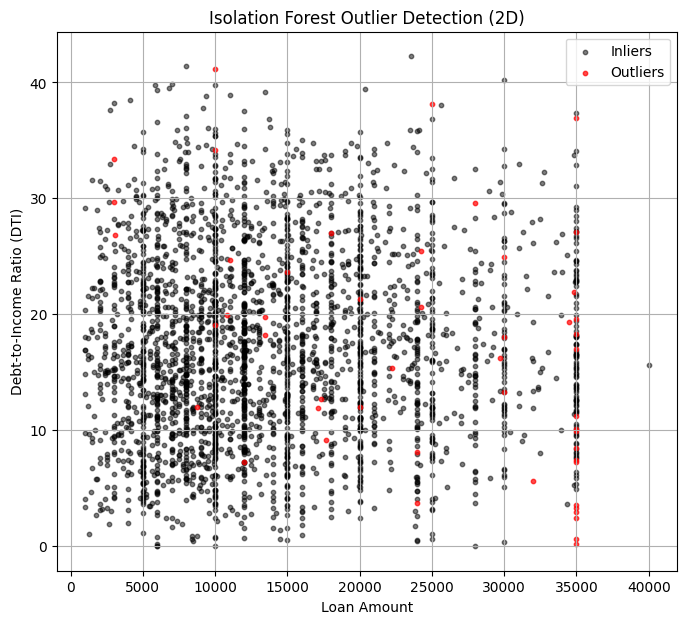

In [13]:
# 대출 규모와 DTI를 이용하여 이상치 시각화
columns = ['loan_amnt', 'dti']
X_viz = X_train[columns].copy()

X_outliers = X_viz.loc[outliers == -1]
X_clean = X_viz.loc[outliers == 1]

# 2D 시각화
X_clean_sample = X_clean.sample(n=3000, random_state=42)
X_outliers_sample = X_outliers.sample(n=50, random_state=42)

plt.figure(figsize=(8, 7))
plt.scatter(X_clean_sample['loan_amnt'], X_clean_sample['dti'],
            c='black', label='Inliers', alpha=0.5, s=10)
plt.scatter(X_outliers_sample['loan_amnt'], X_outliers_sample['dti'],
            c='red', label='Outliers', alpha=0.7, s=10)

plt.xlabel('Loan Amount')
plt.ylabel('Debt-to-Income Ratio (DTI)')
plt.title('Isolation Forest Outlier Detection (2D)')
plt.legend()
plt.grid(True)
plt.savefig('plots/isolation_forest_outlier_detection_2d.png', bbox_inches='tight', dpi=300)

### TSNE를 이용한 차원 축소 및 이상치 시각화

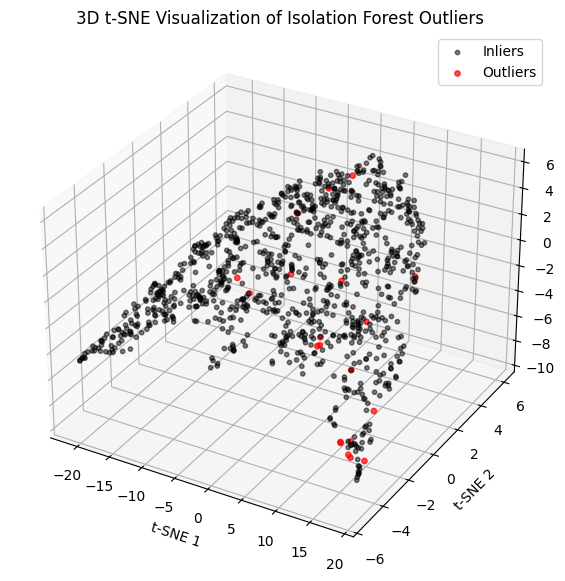

In [14]:
# 4. TSNE를 이용한 이상치 시각화 분석 : 기존 정보로는 시각화 한계가 있어 차원축소 적용

# 수치형 데이터만 추출(약 1만개)하여 T-SNE로 3차원 축소
X_tsne_input_clean = X_train_numeric[outliers==1].sample(n=1000,random_state=42).select_dtypes(include='number')
X_tsne_input_outliers = X_train_numeric[outliers==-1].sample(n=20,random_state=42).select_dtypes(include='number')
X_tsne_input = pd.concat([X_tsne_input_clean,X_tsne_input_outliers], axis=0)

tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X_tsne_input)

# 시각화
labels = np.array([1]*1000 + [-1]*20)
tsne_df = pd.DataFrame(X_tsne, columns=['x', 'y', 'z'])
tsne_df['outlier'] = labels

inliers = tsne_df[tsne_df['outlier'] == 1]
outliers_df = tsne_df[tsne_df['outlier'] == -1]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(inliers['x'], inliers['y'], inliers['z'],
           c='black', label='Inliers', alpha=0.5, s=10)
ax.scatter(outliers_df['x'], outliers_df['y'], outliers_df['z'],
           c='red', label='Outliers', alpha=0.7, s=15)

ax.set_title('3D t-SNE Visualization of Isolation Forest Outliers')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')
ax.legend()
plt.savefig('plots/tsne_visualization.png', bbox_inches='tight', dpi=300)


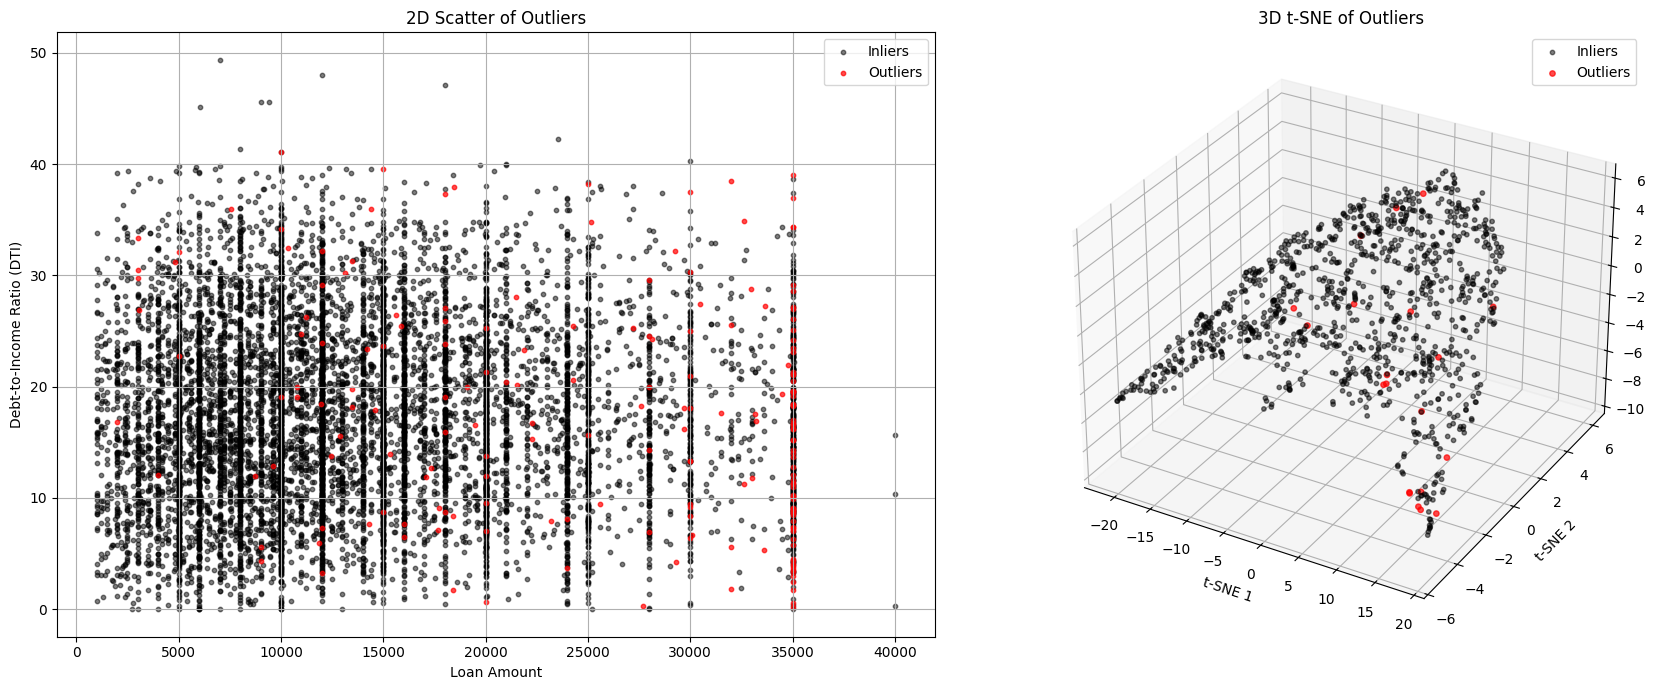

In [15]:
# 병렬 시각화
X_clean_sample = X_clean.sample(n=10000, random_state=42)
X_outliers_sample = X_outliers.sample(n=200, random_state=42)

fig = plt.figure(figsize=(18, 7))

ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(X_clean_sample['loan_amnt'], X_clean_sample['dti'],
            c='black', label='Inliers', alpha=0.5, s=10)
ax1.scatter(X_outliers_sample['loan_amnt'], X_outliers_sample['dti'],
            c='red', label='Outliers', alpha=0.7, s=10)
ax1.set_xlabel('Loan Amount')
ax1.set_ylabel('Debt-to-Income Ratio (DTI)')
ax1.set_title('2D Scatter of Outliers')
ax1.legend()
ax1.grid(True)

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(tsne_df[tsne_df['outlier'] == 1]['x'],
            tsne_df[tsne_df['outlier'] == 1]['y'],
            tsne_df[tsne_df['outlier'] == 1]['z'],
            c='black', label='Inliers', alpha=0.5, s=10)
ax2.scatter(tsne_df[tsne_df['outlier'] == -1]['x'],
            tsne_df[tsne_df['outlier'] == -1]['y'],
            tsne_df[tsne_df['outlier'] == -1]['z'],
            c='red', label='Outliers', alpha=0.7, s=15)
ax2.set_title('3D t-SNE of Outliers')
ax2.set_xlabel('t-SNE 1')
ax2.set_ylabel('t-SNE 2')
ax2.set_zlabel('t-SNE 3')
ax2.legend()

plt.tight_layout()
plt.savefig('plots/tsne_of_outliers.png', bbox_inches='tight', dpi=300)

### Boruta 알고리즘을 활용한 변수선택

In [16]:
# 5. Boruta 알고리즘을 활용한 변수선택 

# 원핫 인코딩된 변수 식별
onehot_columns = X_train_clean.select_dtypes(include='bool').columns.tolist()

# 수치형 + 라벨 인코딩된 변수 선택
X_boruta = X_train_clean.drop(columns=onehot_columns)
y_boruta = y_train_clean.copy()

# Boruta 알고리즘 적용
rf = RandomForestClassifier(max_depth=5, random_state=42, n_jobs=-1)

np.int = np.int64
np.float = np.float64
np.bool = np.bool_

brtfs = BorutaPy(estimator=rf,n_estimators=7,verbose=1,random_state=42,max_iter=15,alpha=0.01)
brtfs.fit(X_boruta.values, y_boruta.values)

selected_features = X_boruta.columns[brtfs.support_].tolist()    
X_selected = X_boruta[selected_features]
X_onehot = X_train_clean[onehot_columns]
print(f"Number of selected features(Non-onehot): {len(selected_features)}")
print(selected_features)

Iteration: 1 / 15
Iteration: 2 / 15
Iteration: 3 / 15
Iteration: 4 / 15
Iteration: 5 / 15
Iteration: 6 / 15
Iteration: 7 / 15
Iteration: 8 / 15
Iteration: 9 / 15
Iteration: 10 / 15
Iteration: 11 / 15
Iteration: 12 / 15
Iteration: 13 / 15
Iteration: 14 / 15


BorutaPy finished running.

Iteration: 	15 / 15
Confirmed: 	10
Tentative: 	2
Rejected: 	2
Number of selected features(Non-onehot): 10
['loan_amnt', 'term', 'int_rate', 'installment', 'sub_grade', 'annual_inc', 'dti', 'revol_bal', 'revol_util', 'mort_acc']


In [17]:
# 최종 훈련데이터 가공 완료
X_train_brtfs = pd.concat([X_selected, X_onehot], axis=1)
X_train_brtfs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 274448 entries, 214484 to 257563
Data columns (total 40 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            274448 non-null  float64
 1   term                                 274448 non-null  int64  
 2   int_rate                             274448 non-null  float64
 3   installment                          274448 non-null  float64
 4   sub_grade                            274448 non-null  int64  
 5   annual_inc                           274448 non-null  float64
 6   dti                                  274448 non-null  float64
 7   revol_bal                            274448 non-null  float64
 8   revol_util                           274448 non-null  float64
 9   mort_acc                             274448 non-null  float64
 10  home_ownership_OTHER                 274448 non-null  bool   
 11  home_ownershi

## 4. 모델 구축 및 평가

### 클래스 불균형 문제 및 교차 검증 개선

표본의 수 및 칼럼의 수가 그리 많지 않으므로 Oversampling을 통해 클래스 불균형을 해소.

ADASYN 적용시 아래와 같은 문제가 발생할 수 있으므로, **imblearn.pipeline**을 사용하여 Oversampling 적용

1. **검증 무결성 이슈 (Validation Integrity Issue)**: ADASYN으로 생성된 합성 데이터가 교차 검증(CV) 과정에서 훈련 및 검증 폴드에 모두 포함

2. **과대평가된 성능 지표 (Inflated Performance Metrics)**: 검증 세트에 합성 데이터가 포함되면, 모델은 사실상 훈련 데이터의 변형된 버전으로 평가되어 성능이 과대평가

3. **과적합 위험 (Overfitting Risk)**: 합성 데이터로 검증하면 모델이 실제 데이터에 대한 일반화 능력 대신 합성 패턴을 학습할 위험

**imblearn.pipeline**을 사용시 교차 검증의 각 폴드 내에서만 오버샘플링이 적용되므로,

- 각 CV 폴드의 **훈련 데이터에만** ADASYN이 적용됨
- 검증은 항상 **원본 데이터**로만 수행됨
- 모델의 실제 성능을 더 정확하게 평가할 수 있음

### XGBoost 모델 최적화 이단계 접근법

XGBoost 모델의 하이퍼파라미터 튜닝에 이단계 접근법(Two-Step Optimization)을 적용:

**1단계: 초기 하이퍼파라미터 탐색**
- 상대적으로 높은 학습률(0.1)과 고정된 n_estimators 값으로 하이퍼파라미터 조합을 탐색
- 각 하이퍼파라미터 조합이 동일한 학습 기회(같은 트리 개수)를 갖도록 보장
- 교차 검증 내에서 ADASYN 오버샘플링을 정확히 적용

**2단계: 최적 모델 미세 조정**
- 1단계에서 찾은 최적 하이퍼파라미터에 낮은 학습률(0.01)과 높은 n_estimators(10000) 적용
- early_stopping_rounds를 사용하여 최적의 트리 개수 결정
- 전체 훈련 데이터와 검증 데이터를 사용하여 최종 모델 학습

**이러한 접근법의 이점:**
- 공정한 하이퍼파라미터 비교: 1단계에서 모든 조합이 동일한 tree 개수로 평가됨
- 과적합 방지: 낮은 학습률과 early stopping으로 모델 안정성 향상
- 계산 효율성: 미세 조정은 최적 하이퍼파라미터 조합에만 수행

In [18]:
# 1단계: 초기 하이퍼파라미터 탐색 - 높은 학습률로 여러 조합 탐색

# 하이퍼파라미터 검색 결과를 저장할 경로 설정
hp_search_results_path = 'model_results/hp_search_results.pkl'

# 이미 저장된 하이퍼파라미터 결과가 있는지 확인
if os.path.exists(hp_search_results_path):
    print("저장된 하이퍼파라미터 검색 결과를 불러옵니다...")
    with open(hp_search_results_path, 'rb') as f:
        step1_search = pickle.load(f)
    
    print("최적 하이퍼파라미터:")
    print(step1_search.best_params_)
    print("최고 F1 점수 (CV):", step1_search.best_score_)
    
    # 상위 5개 하이퍼파라미터 조합 확인
    step1_results = pd.DataFrame(step1_search.cv_results_)
    columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    top_5_params = step1_results[columns].sort_values('rank_test_score').head(5)
    print("\n상위 5개 하이퍼파라미터 조합:")
    print(top_5_params)
else:
    # ADASYN을 파이프라인 내에서 적용하여 교차 검증 시 검증 데이터 무결성 유지
    step1_pipeline = ImbPipeline([
        ('sampler', ADASYN(random_state=42)),
        ('classifier', XGBClassifier(eval_metric='logloss', random_state=42, learning_rate=0.1))
    ])
    
    # 하이퍼파라미터 설정 - 고정된 n_estimators로 공정한 비교 보장
    param_dist = {
        'classifier__n_estimators': [100, 300, 500],  # 고정된 값으로 탐색
        'classifier__max_depth': [3, 5, 7, 9],
        'classifier__min_child_weight': [0, 0.1, 0.3, 0.5],
        'classifier__gamma': [0, 0.1, 1],
        'classifier__subsample': [0.6, 0.8, 1.0],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__reg_alpha': [0, 0.1, 1],
        'classifier__reg_lambda': [1, 5, 10]
    }
    
    # RandomizedSearchCV - 각 CV 폴드 내에서 올바르게 ADASYN 적용
    step1_search = RandomizedSearchCV(
        estimator=step1_pipeline,
        param_distributions=param_dist,
        n_iter=25,  # 계산 자원에 따라 조정 가능
        scoring='f1',
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    
    # 1단계 모델 훈련
    print("1단계: 초기 하이퍼파라미터 탐색 중...")
    step1_search.fit(X_train_brtfs, y_train_clean)
    
    # 최적 하이퍼파라미터 출력
    print("최적 하이퍼파라미터:")
    print(step1_search.best_params_)
    print("최고 F1 점수 (CV):", step1_search.best_score_)
    
    # 상위 5개 하이퍼파라미터 조합 확인
    step1_results = pd.DataFrame(step1_search.cv_results_)
    columns = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
    top_5_params = step1_results[columns].sort_values('rank_test_score').head(5)
    print("\n상위 5개 하이퍼파라미터 조합:")
    print(top_5_params)
    
    # 하이퍼파라미터 검색 결과 저장
    print("\n하이퍼파라미터 검색 결과를 저장합니다...")
    with open(hp_search_results_path, 'wb') as f:
        pickle.dump(step1_search, f)

저장된 하이퍼파라미터 검색 결과를 불러옵니다...
최적 하이퍼파라미터:
{'classifier__subsample': 1.0, 'classifier__reg_lambda': 5, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 0.1, 'classifier__max_depth': 7, 'classifier__gamma': 1, 'classifier__colsample_bytree': 1.0}
최고 F1 점수 (CV): 0.9354467284124377

상위 5개 하이퍼파라미터 조합:
                                               params  mean_test_score  \
12  {'classifier__subsample': 1.0, 'classifier__re...         0.935447   
2   {'classifier__subsample': 1.0, 'classifier__re...         0.935404   
4   {'classifier__subsample': 0.8, 'classifier__re...         0.935399   
16  {'classifier__subsample': 1.0, 'classifier__re...         0.935357   
19  {'classifier__subsample': 0.8, 'classifier__re...         0.935303   

    std_test_score  rank_test_score  
12        0.000453                1  
2         0.000466                2  
4         0.000485                3  
16        0.000471                4  
19        0.000493     

### 최적 모델 미세 조정 및 성능 평가

1단계를 바탕으로 학습률을 낮추고(0.01), 트리를 늘리고(10000), 조기 중단을 적용하여 최종 모델을 학습

저장된 최종 모델을 불러옵니다...
최적 트리 개수: 2401
최적 트리 개수: 2401


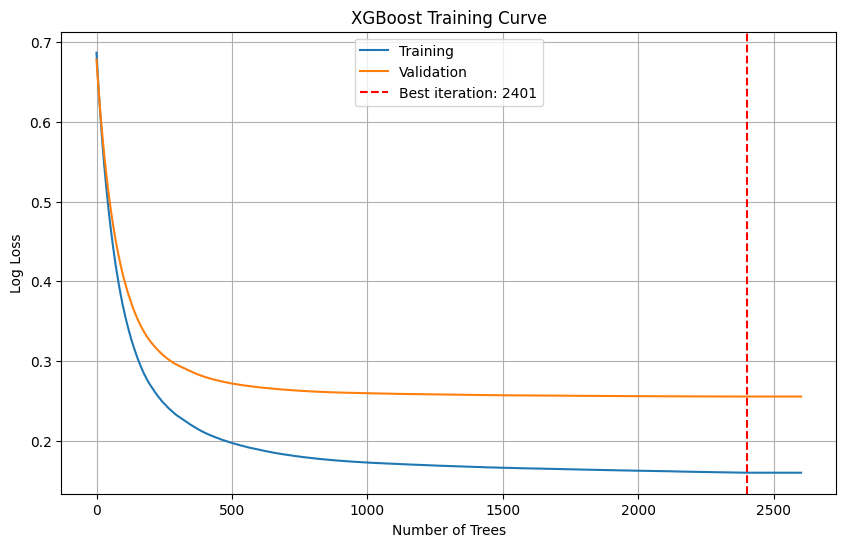

In [19]:
# 2단계: 최적 모델 미세 조정 - 낮은 학습률, 높은 n_estimators, early stopping

# 최종 모델 파일 경로
final_model_path = 'model_results/final_model.pkl'

# 1단계에서 찾은 최적 하이퍼파라미터 가져오기
best_params = step1_search.best_params_

# 테스트 데이터 준비
X_test_brtfs = X_test[selected_features + onehot_columns].copy()

# 검증용 데이터셋 분할 (원본 데이터에서 10%를 검증에 사용)
from sklearn.model_selection import train_test_split
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_brtfs, y_train_clean, test_size=0.1, random_state=42, stratify=y_train_clean
)

# 이미 학습된 최종 모델이 있는지 확인
if os.path.exists(final_model_path):
    print("저장된 최종 모델을 불러옵니다...")
    with open(final_model_path, 'rb') as f:
        final_model = pickle.load(f)
        # 저장된 평가 결과 불러오기
    evals_result_path = 'model_results/evals_result.pkl'
    if os.path.exists(evals_result_path):
        with open(evals_result_path, 'rb') as f:
            evals_result = pickle.load(f)
    # 최적 트리 개수 확인 (XGBoost 버전에 따라 속성 이름이 다를 수 있음)
    best_iteration = final_model.best_iteration if hasattr(final_model, 'best_iteration') else None
    print(f"최적 트리 개수: {best_iteration}")
else:
    # ADASYN 적용 (최종 훈련 데이터에만)
    adasyn = ADASYN(random_state=42)
    X_train_final_resampled, y_train_final_resampled = adasyn.fit_resample(X_train_final, y_train_final)
    
    # 최종 모델 생성 - 낮은 학습률, 높은 n_estimators, early stopping 적용
    final_model = XGBClassifier(
        # 1단계에서 찾은 최적 하이퍼파라미터 적용
        max_depth=int(best_params['classifier__max_depth']),
        min_child_weight=best_params['classifier__min_child_weight'],
        gamma=best_params['classifier__gamma'],
        subsample=best_params['classifier__subsample'],
        colsample_bytree=best_params['classifier__colsample_bytree'],
        reg_alpha=best_params['classifier__reg_alpha'],
        reg_lambda=best_params['classifier__reg_lambda'],
        # 미세 조정을 위한 파라미터
        learning_rate=0.01,           # 낮은 학습률
        n_estimators=10000,           # 많은 트리 개수
        early_stopping_rounds=200,    # 조기 중단
        eval_metric='logloss',        # 평가 지표
        random_state=42,
        verbosity=1
    )
    
    # 최종 모델 훈련 - 검증 데이터로 early stopping 모니터링
    print("\n2단계: 최적 모델 미세 조정 중...")
    final_model.fit(
        X_train_final_resampled, y_train_final_resampled,
        eval_set=[(X_train_final_resampled, y_train_final_resampled), 
                  (X_val_final, y_val_final)],
        verbose=True
    )
    
    # 학습 결과 및 모델 저장
    with open(final_model_path, 'wb') as f:
        pickle.dump(final_model, f)
    
    # 평가 결과 저장
    evals_result = final_model.evals_result()
    with open('model_results/evals_result.pkl', 'wb') as f:
        pickle.dump(evals_result, f)

# 최적 트리 개수 확인 (XGBoost 버전에 따라 속성 이름이 다를 수 있음)
best_iteration = final_model.best_iteration if hasattr(final_model, 'best_iteration') else None
print(f"최적 트리 개수: {best_iteration}")

# 학습 곡선 시각화
plt.figure(figsize=(10, 6))
plt.plot(evals_result['validation_0']['logloss'], label='Training')
plt.plot(evals_result['validation_1']['logloss'], label='Validation')
plt.axvline(x=best_iteration, color='r', linestyle='--', label=f'Best iteration: {best_iteration}')
plt.xlabel('Number of Trees')
plt.ylabel('Log Loss')
plt.title('XGBoost Training Curve')
plt.legend()
plt.grid(True)
plt.savefig('plots/learning_curve.png', bbox_inches='tight', dpi=300)

# 테스트 데이터에 대한 예측
y_pred_best = final_model.predict(X_test_brtfs)
y_proba_best = final_model.predict_proba(X_test_brtfs)[:, 1]

### 최종 모델 성능 평가

In [20]:
# 평가 지표 출력
print("\n<< 최종 XGBoost 모델 성능 >>")
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba_best))
print("\n분류 보고서:")
print(classification_report(y_test, y_pred_best))


<< 최종 XGBoost 모델 성능 >>
F1 Score: 0.9354695016927006
ROC AUC: 0.9081721636844388

분류 보고서:
              precision    recall  f1-score   support

           0       0.92      0.48      0.63     23302
           1       0.89      0.99      0.94     95507

    accuracy                           0.89    118809
   macro avg       0.90      0.74      0.78    118809
weighted avg       0.89      0.89      0.88    118809



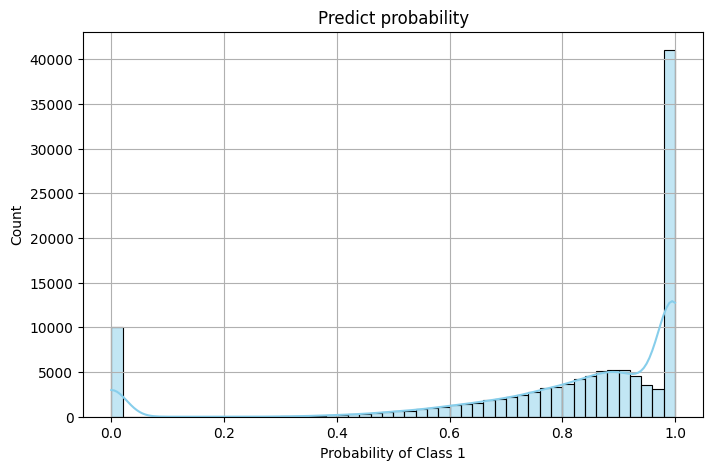

In [21]:
# 예측 확률 시각화
plt.figure(figsize=(8, 5))
sns.histplot(y_proba_best, bins=50, kde=True, color='skyblue')
plt.title("Predict probability")
plt.xlabel("Probability of Class 1")
plt.ylabel("Count")
plt.grid(True)
plt.savefig('plots/prediction_probability.png', bbox_inches='tight', dpi=300)

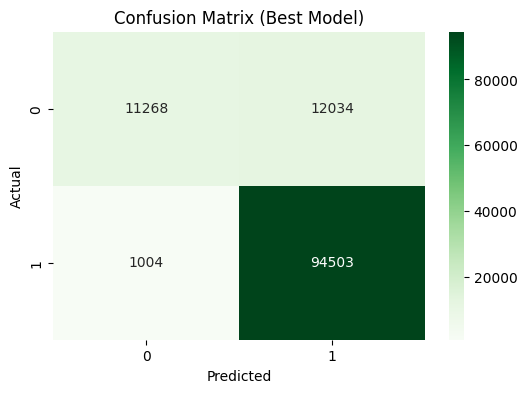

In [22]:
# Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Best Model)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('plots/confusion_matrix.png', bbox_inches='tight', dpi=300)

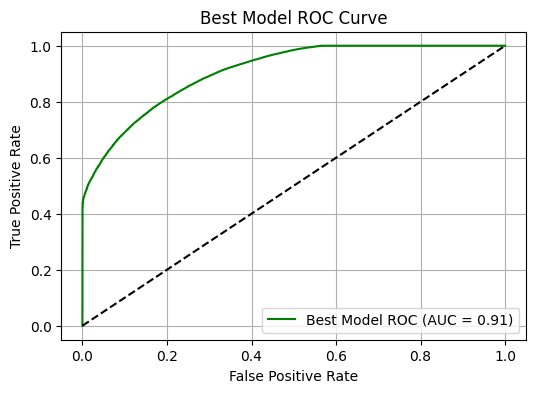

In [23]:
# ROC Curve
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)
plt.figure(figsize=(6,4))
plt.plot(fpr_best, tpr_best, label=f'Best Model ROC (AUC = {roc_auc_score(y_test, y_proba_best):.2f})', color='green')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Best Model ROC Curve')
plt.legend()
plt.grid(True)
plt.savefig('plots/roc_curve.png', bbox_inches='tight', dpi=300)

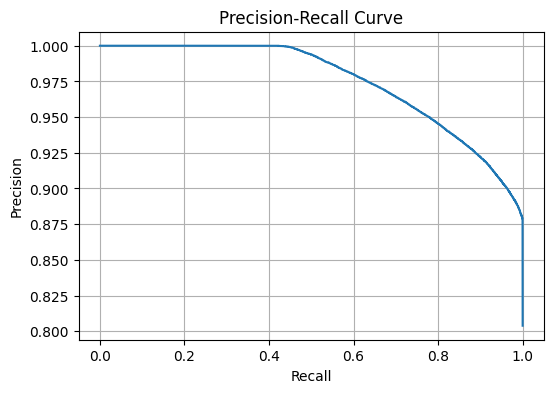

In [24]:
# precision recall curve

precision, recall, _ = precision_recall_curve(y_test, y_proba_best)
avg_precision = average_precision_score(y_test, y_proba_best)
plt.close()

plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.savefig('plots/precision_recall_curve.png', bbox_inches='tight', dpi=300)
plt.show()

### 기본 변수 중요도 분석

XGBoost의 기본 변수 중요도는 모델 전체에서 각 특성이 얼마나 자주 사용되었는지를 보여줍니다.

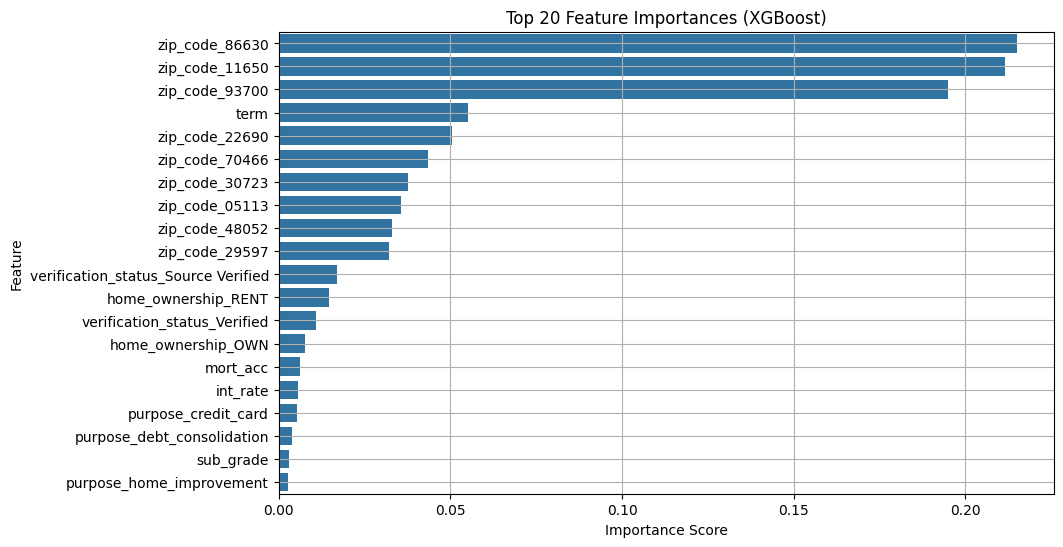

In [25]:
# 상위 20개 feature importance
importances = final_model.feature_importances_
features = X_test_brtfs.columns

top_idx = importances.argsort()[::-1][:20]
top_features = features[top_idx]
top_importances = importances[top_idx]

plt.figure(figsize=(10,6))
sns.barplot(x=top_importances, y=top_features)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.grid(True)
plt.savefig('plots/feature_importance.png', bbox_inches='tight', dpi=300)

### SHAP를 활용한 모델 해석

**개별 예측에 대한 특성 기여도**를 파악하기 위한 **SHAP(SHapley Additive exPlanations)** 분석

In [26]:
# SHAP TreeExplainer 생성
explainer = shap.TreeExplainer(final_model)

# 훈련 데이터의 일부 샘플에 대한 SHAP 값 계산 (전체 데이터셋은 메모리 이슈가 있을 수 있음)
X_train_sample = X_train_brtfs.sample(n=1000, random_state=42)
shap_values = explainer.shap_values(X_train_sample)

# 기대값 출력 (모델의 기본 예측값)
print("모델의 기본 예측값 (base value):", explainer.expected_value)

모델의 기본 예측값 (base value): 0.030521782


In [27]:
# 특정 샘플 예측에 대한 SHAP 값 분석
# 부도 사례와 정상 상환 사례 각각 하나씩 선택
loan_idx_default = X_train_sample.index[y_train[X_train_sample.index] == 1][0]  # 부도 사례
loan_idx_paid = X_train_sample.index[y_train[X_train_sample.index] == 0][0]     # 정상 상환 사례

# 선택된 대출 사례의 특성 값 출력
print("부도 대출 사례 특성:")
print(X_train_brtfs.loc[loan_idx_default, :].head(10))
print("\n정상 상환 대출 사례 특성:")
print(X_train_brtfs.loc[loan_idx_paid, :].head(10))

# 실제 클래스 확인
print("\n부도 사례 실제 클래스:", y_train.loc[loan_idx_default])
print("정상 상환 사례 실제 클래스:", y_train.loc[loan_idx_paid])

# 예측 확률 확인
print("\n부도 사례 예측 확률:", final_model.predict_proba(X_train_brtfs.loc[loan_idx_default:loan_idx_default, :])[0][1])
print("정상 상환 사례 예측 확률:", final_model.predict_proba(X_train_brtfs.loc[loan_idx_paid:loan_idx_paid, :])[0][1])

부도 대출 사례 특성:
loan_amnt       8075.0
term                36
int_rate         17.57
installment      290.2
sub_grade           16
annual_inc     30000.0
dti               23.2
revol_bal       4103.0
revol_util        80.5
mort_acc           5.0
Name: 96288, dtype: object

정상 상환 대출 사례 특성:
loan_amnt       6000.0
term                36
int_rate         16.29
installment     211.81
sub_grade           16
annual_inc     40404.0
dti              13.72
revol_bal       4770.0
revol_util        58.2
mort_acc           0.0
Name: 44427, dtype: object

부도 사례 실제 클래스: 1
정상 상환 사례 실제 클래스: 0

부도 사례 예측 확률: 0.9998288
정상 상환 사례 예측 확률: 0.00026364822


아래의 SHAP Force Plot은 개별 대출 사례에 대한 모델의 예측을 설명합니다:

- **빨간색** 특성은 부도 확률을 **증가**시키는 요인
- **파란색** 특성은 부도 확률을 **감소**시키는 요인
- 각 특성의 **너비**는 그 영향력의 **크기**를 나타냄
- **base value**는 데이터셋 전체의 평균 예측값
- **output value**는 해당 사례의 최종 예측값

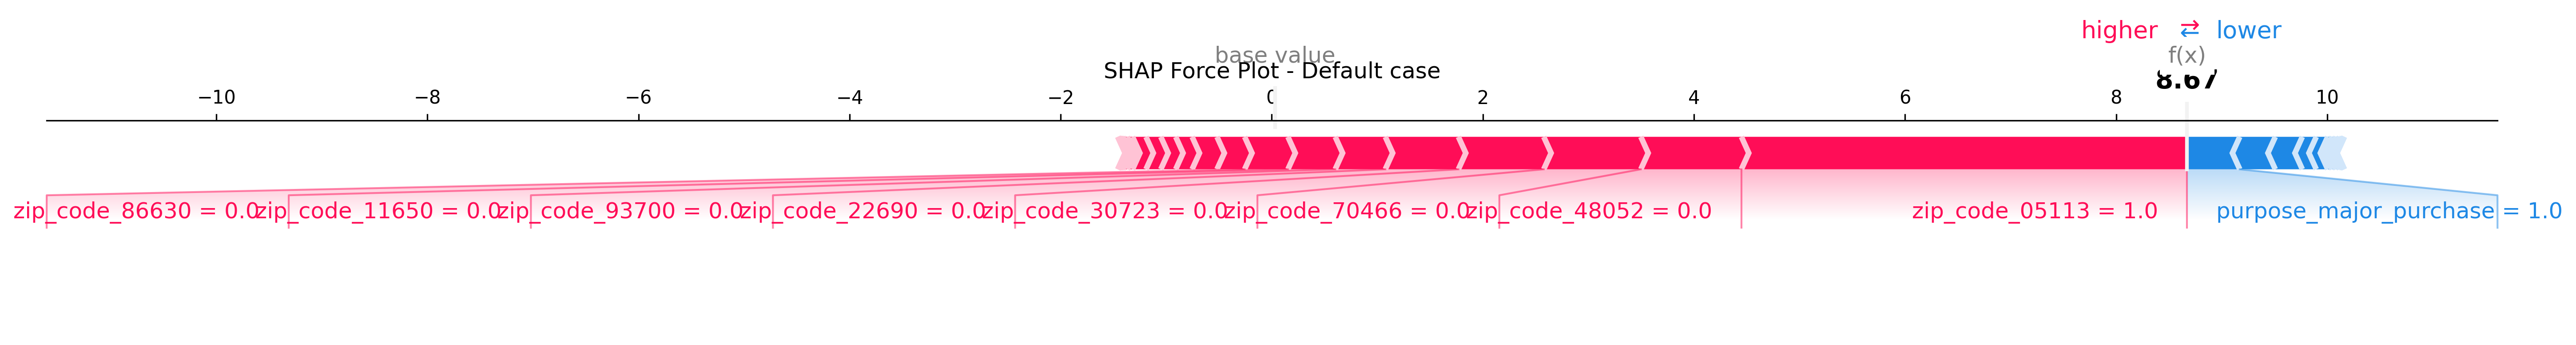

<Figure size 1600x500 with 0 Axes>

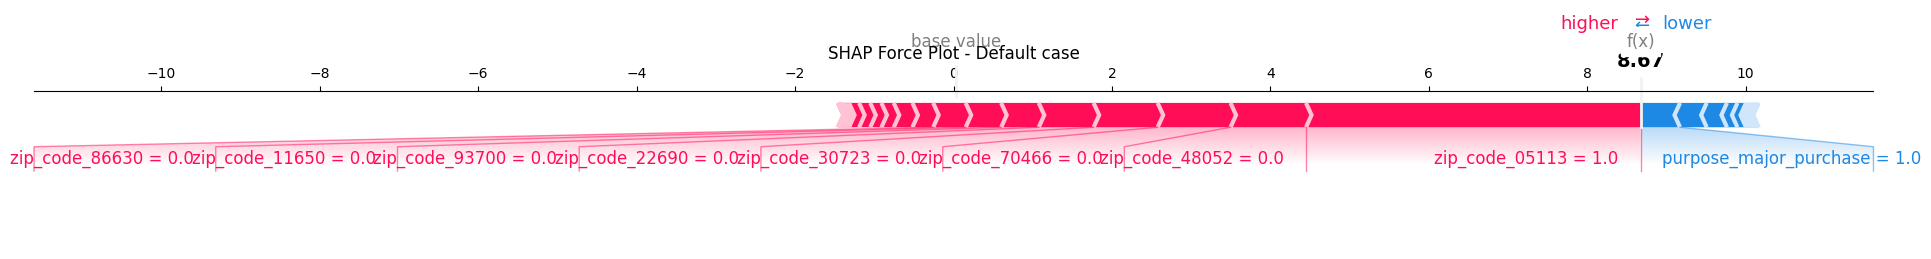

In [28]:
# SHAP Force Plot - 부도 사례
plt.figure(figsize=(16, 5))
shap_idx_default = np.where(np.array(X_train_sample.index) == loan_idx_default)[0][0]
shap.force_plot(explainer.expected_value, 
                shap_values[shap_idx_default, :],
                X_train_sample.iloc[shap_idx_default, :],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot - Default case")
plt.tight_layout()
plt.savefig('plots/shap_force_plot_default.png', bbox_inches='tight', dpi=300)
display(Image(filename="plots/shap_force_plot_default.png"))

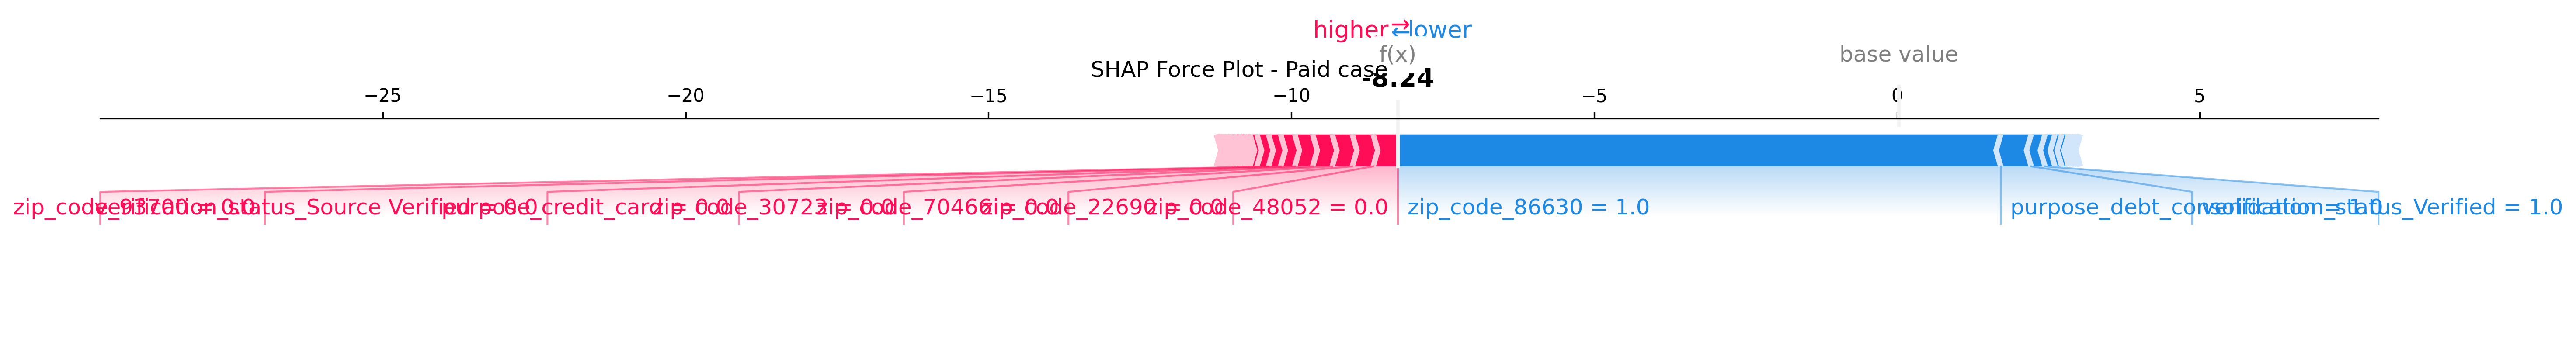

In [29]:
# SHAP Force Plot - 정상 상환 사례
plt.figure(figsize=(16, 5))
shap_idx_paid = np.where(np.array(X_train_sample.index) == loan_idx_paid)[0][0]
shap.force_plot(explainer.expected_value, 
                shap_values[shap_idx_paid, :],
                X_train_sample.iloc[shap_idx_paid, :],
                matplotlib=True, show=False)
plt.title("SHAP Force Plot - Paid case")
plt.tight_layout()
plt.savefig('plots/shap_force_plot_paid.png', bbox_inches='tight', dpi=300)
display(Image(filename="plots/shap_force_plot_paid.png"))

### SHAP 글로벌 분석 - 전체 특성 중요도

/var/folders/n2/jbh_0_091bx8qgz7j87t2qwc0000gp/T/ipykernel_10403/2148368487.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_sample, plot_type="bar", show=False)


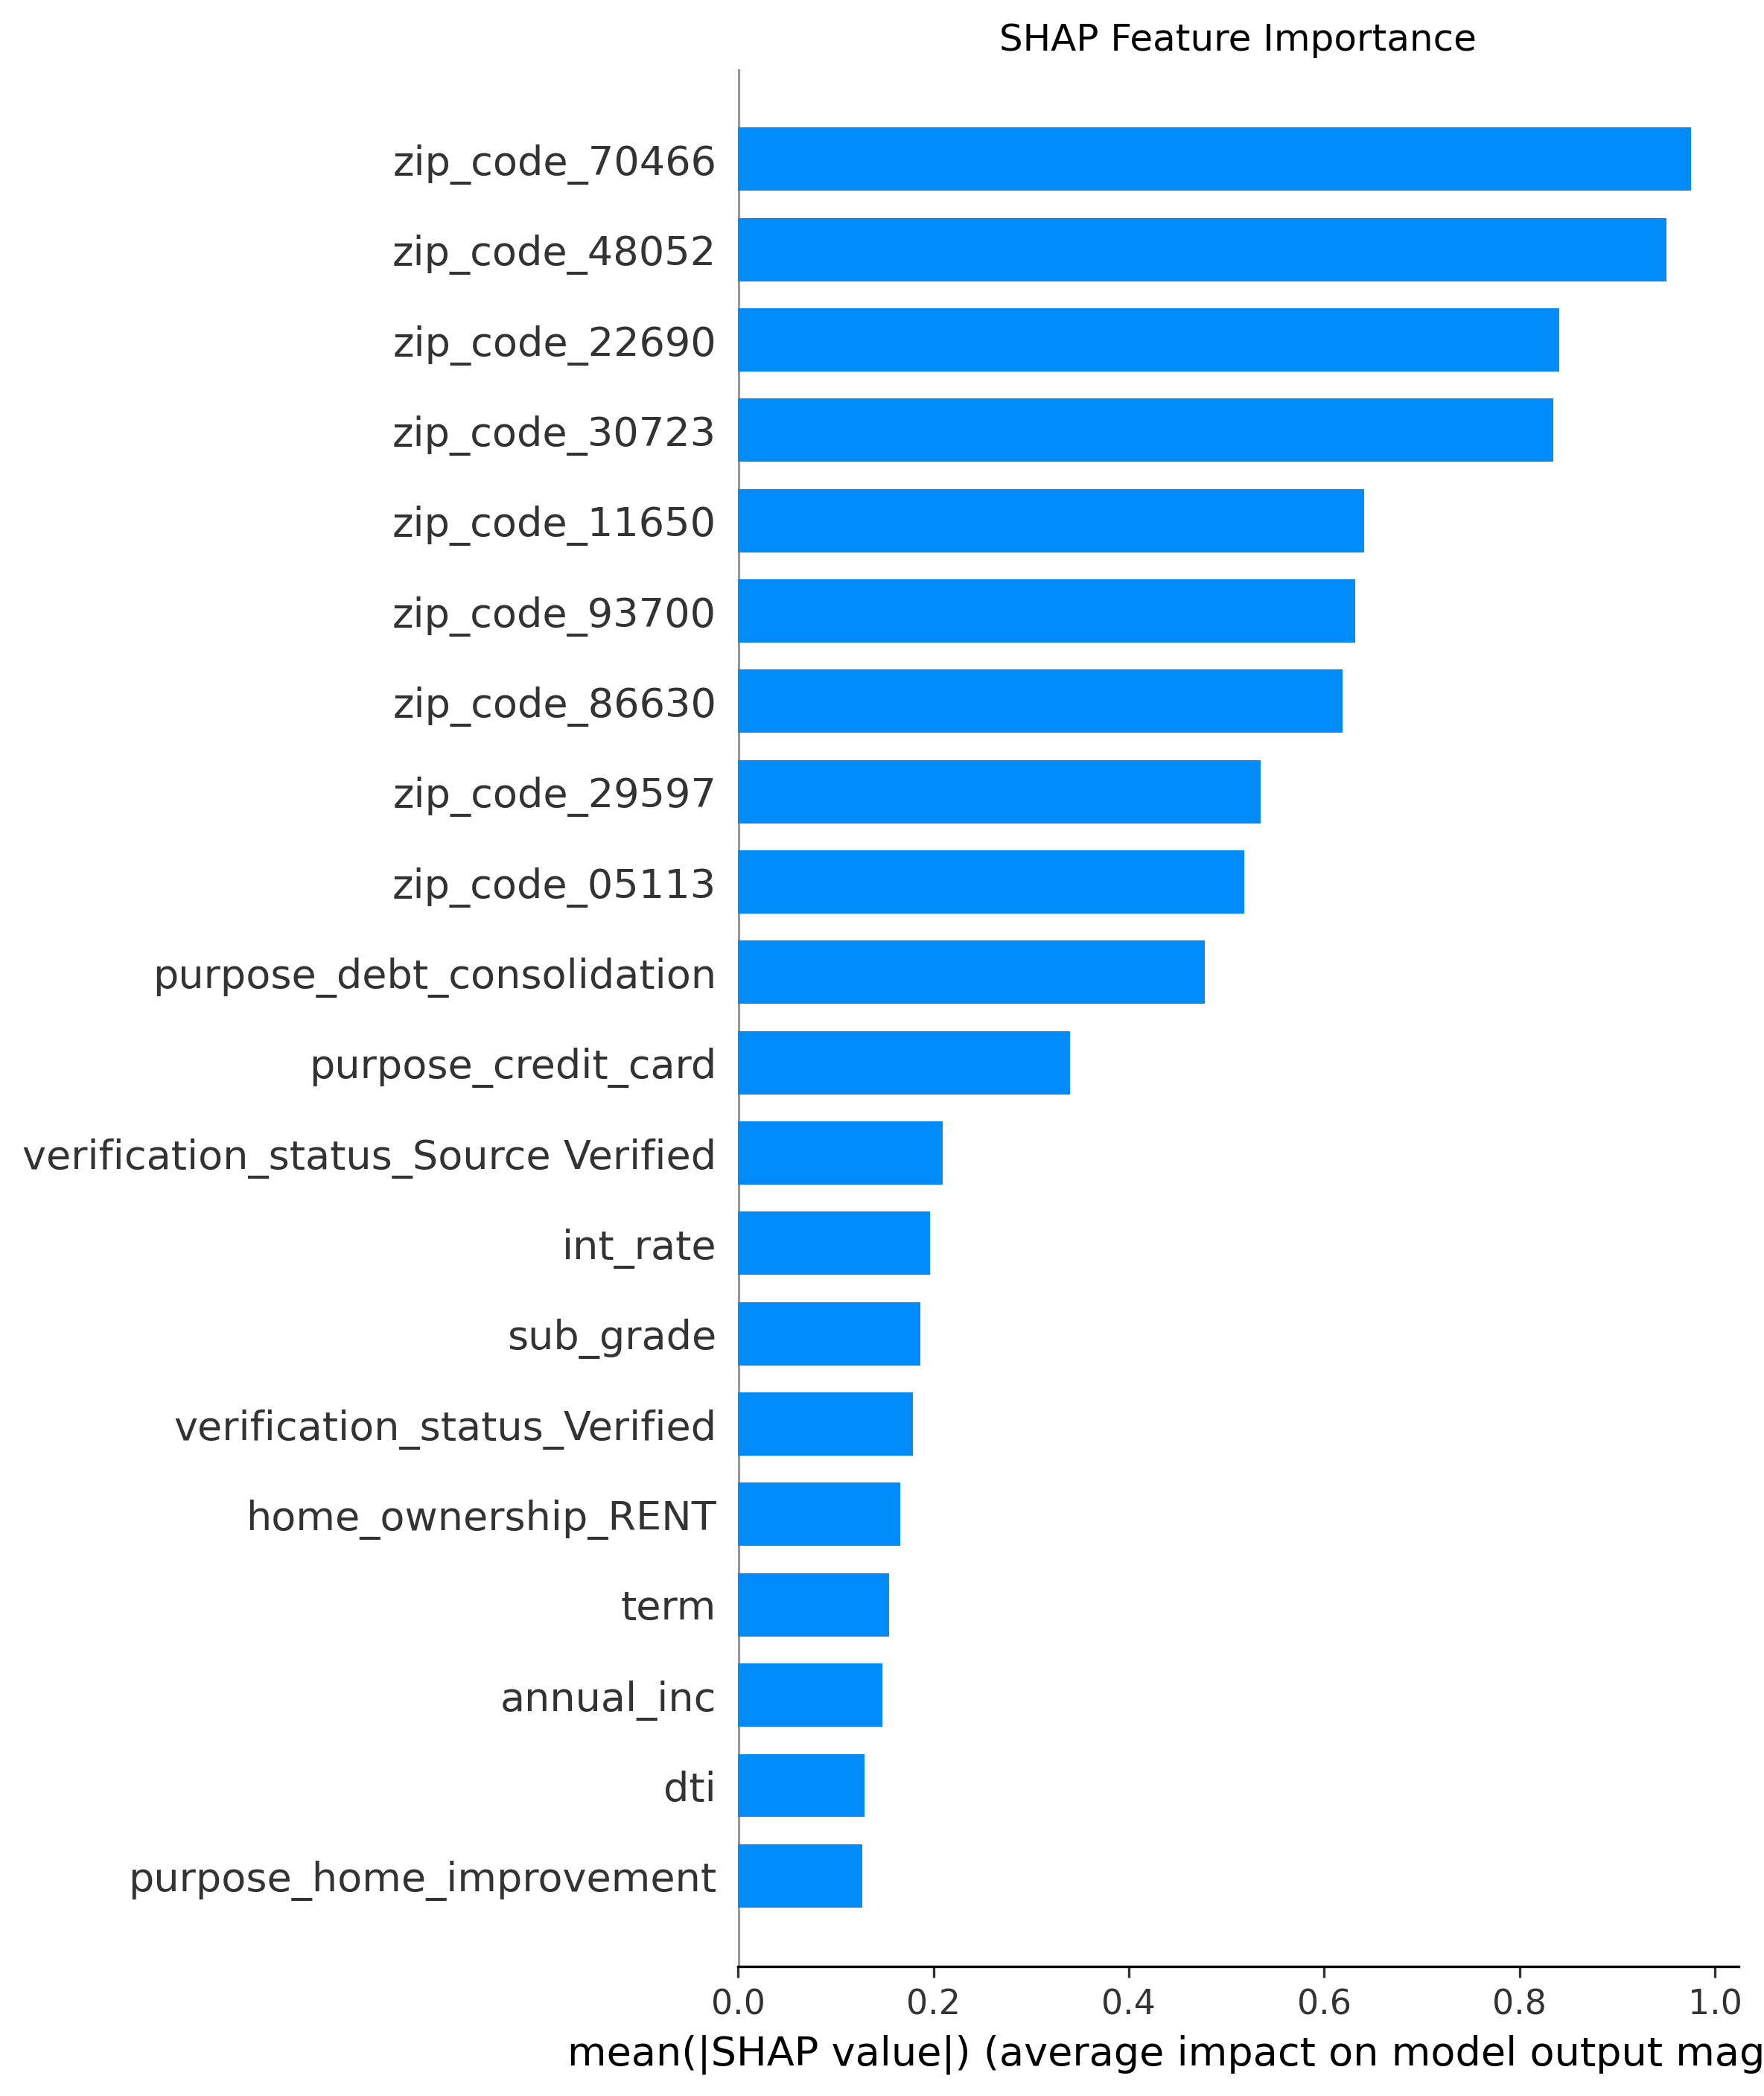

In [30]:
# SHAP Summary Plot - 모든 특성의 영향력 시각화
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_train_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.savefig('plots/shap_feature_importance.png', bbox_inches='tight', dpi=300)
display(Image(filename="plots/shap_feature_importance.png"))

/var/folders/n2/jbh_0_091bx8qgz7j87t2qwc0000gp/T/ipykernel_10403/548226622.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train_sample, show=False)


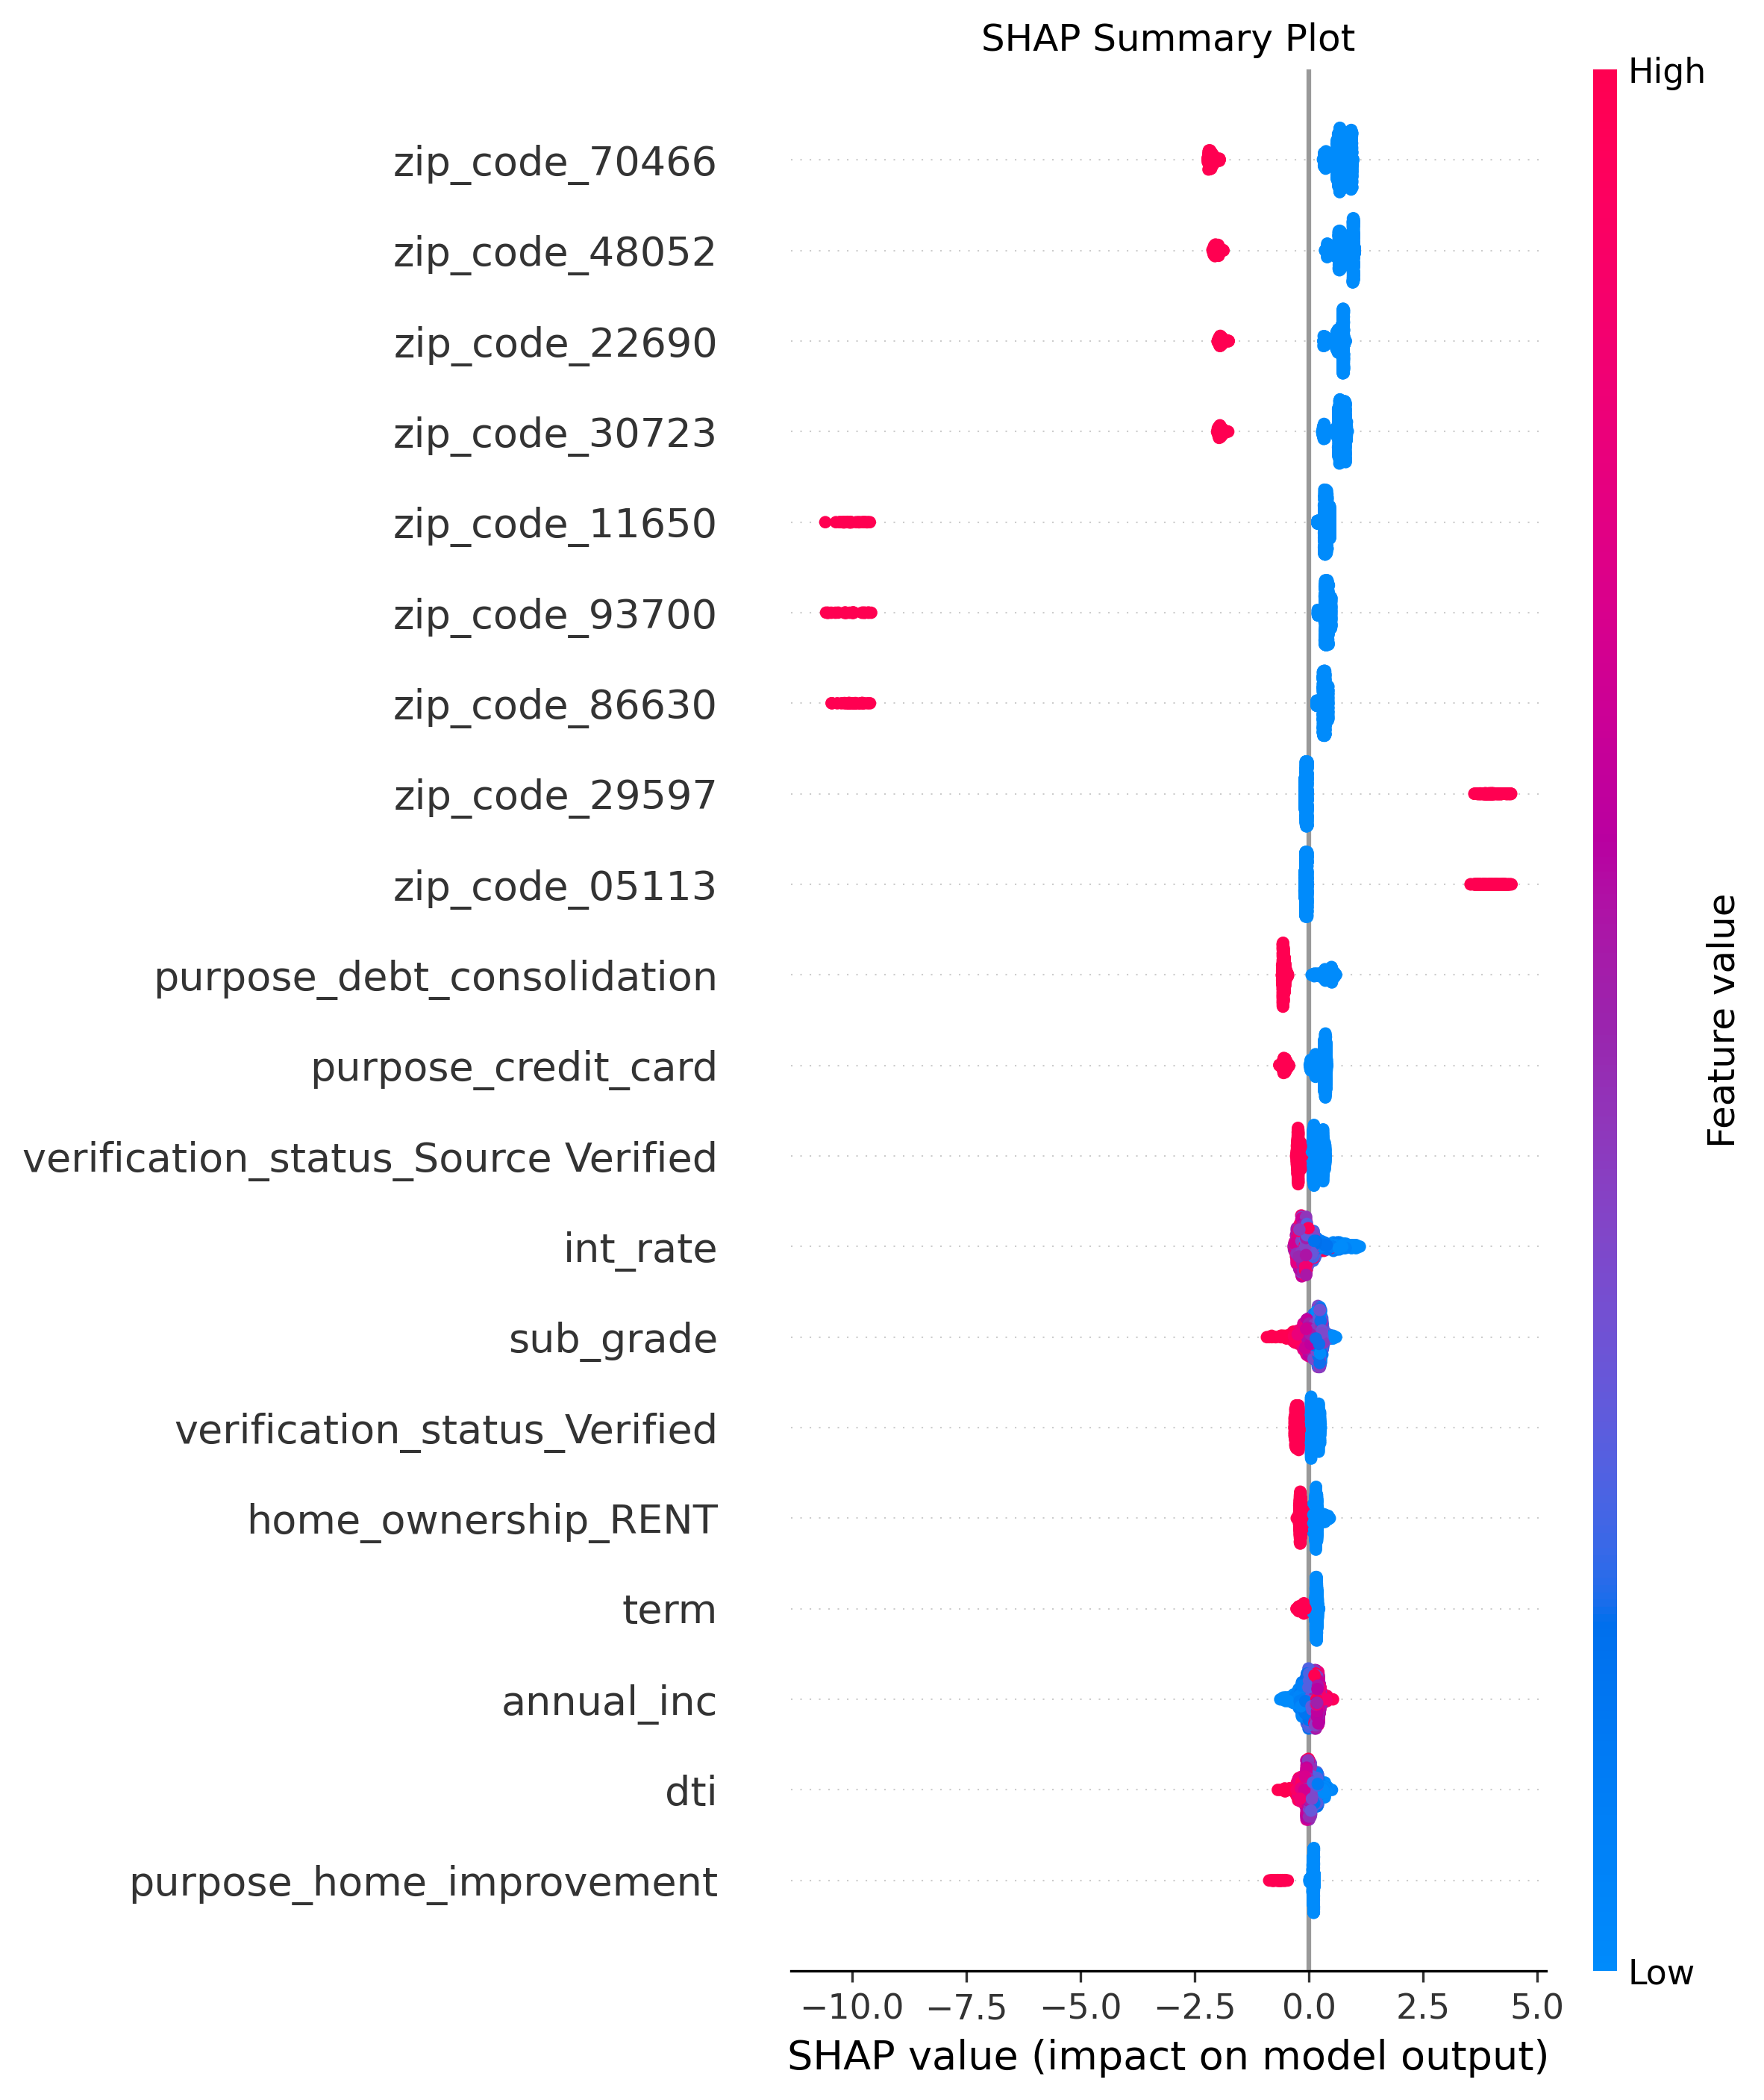

In [31]:
# SHAP Summary Plot - 각 특성값에 따른 영향력 변화 시각화
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_train_sample, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.savefig('plots/shap_summary_plot.png', bbox_inches='tight', dpi=300)
display(Image(filename="plots/shap_summary_plot.png"))

SHAP 요약 플롯의 해석:

1. **Feature Importance**:
   - 막대 그래프는 각 특성의 평균 절대 SHAP 값 기준 중요도를 보여줍니다.
   - XGBoost의 기본 feature_importance와 달리 각 예측에 대한 기여도의 평균입니다.

2. **Summary Plot**:
   - 각 점은 하나의 샘플에 대한 하나의 특성 값을 나타냅니다.
   - 색상: 특성 값이 **높을수록 빨간색**, **낮을수록 파란색**
   - 수평 위치: SHAP 값으로, **오른쪽**은 부도 확률을 **증가**시키고, **왼쪽**은 **감소**시킴
   - 이를 통해 특성 값의 변화에 따른 모델 예측 영향을 파악할 수 있습니다.

예를 들어, 일부 특성들은 값이 증가할수록 부도 확률이 높아지는 반면(빨간 점이 오른쪽에 위치), 
다른 특성들은 값이 낮을수록 부도 확률이 높아집니다(파란 점이 오른쪽에 위치).

## 결론

본 분석에서는 XGBoost 알고리즘을 사용하여 은행 대출의 부도 여부를 예측하는 모델을 구축했습니다. 주요 결론은 다음과 같습니다:

1. **데이터 전처리**: 결측치 처리, 이상치 제거, Boruta 알고리즘을 통한 변수 선택을 수행하여 모델의 기반을 마련했습니다.

2. **클래스 불균형 처리**: 계층적 샘플링으로 훈련/테스트 세트의 클래스 분포를 유지하고, ADASYN 알고리즘을 교차 검증 내에서 올바르게 적용하여 소수 클래스에 대한 예측 성능을 개선했습니다.

3. **이단계 최적화 접근법**: 
   - 초기 하이퍼파라미터 탐색 단계에서는 고정된 n_estimators로 공정한 비교를 수행
   - 최종 모델 구축 단계에서는 낮은 학습률과 early stopping을 적용하여 최적의 트리 개수를 찾음

4. **모델 해석**: 
   - XGBoost 변수 중요도를 통해 주요 특성들을 식별
   - SHAP 분석을 통해 개별 대출 사례에 대한 예측 근거를 파악하고, 특성값 변화에 따른 예측 영향을 이해

5. **성능 평가**: F1 점수, ROC-AUC, 정밀도-재현율 곡선 등 다양한 지표를 통해 모델의 성능을 종합적으로 평가했습니다.

이러한 접근법은 단순히 높은 예측 정확도를 달성하는 것을 넘어, 모델의 예측 결정을 이해하고 설명할 수 있는 프레임워크를 제공합니다.

## Appendix : 여러 Gradiant boosting 모델의 성능 비교

In [32]:
# 비교 : Catboost

# 파이프라인 구성: ADASYN + CatBoost
cat_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=42)),
    ('classifier', CatBoostClassifier(verbose=0, random_state=42))
])

# CatBoost 하이퍼파라미터 공간
cat_params = {
    'classifier__depth': [4, 6, 8, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__iterations': [200, 500, 1000],
    'classifier__l2_leaf_reg': [1, 3, 5, 7]
}

# RandomizedSearchCV 구성
cat_search = RandomizedSearchCV(
    estimator=cat_pipeline,
    param_distributions=cat_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 조기 종료 설정
fit_params = {
    'classifier__early_stopping_rounds': 50,
    'classifier__eval_set': [(X_test_brtfs, y_test)],
    'classifier__use_best_model': True
}

print("CatBoost + ADASYN 파이프라인 탐색 중...")
cat_search.fit(X_train_brtfs, y_train_clean, **fit_params)

# 최적 모델 추출
best_cat = cat_search.best_estimator_

# 예측
y_pred_best = best_cat.predict(X_test_brtfs)
y_proba_best = best_cat.predict_proba(X_test_brtfs)[:, 1]

# 평가 지표 출력
print("<< Best Catboost model performance >>")
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

CatBoost + ADASYN 파이프라인 탐색 중...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/hwan/.pyenv/versions/3.10.14/envs/hwan/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


<< Best Catboost model performance >>
F1 Score: 0.9355322634768363
ROC AUC: 0.9072642177106306

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.47      0.63     23302
           1       0.88      0.99      0.94     95507

    accuracy                           0.89    118809
   macro avg       0.91      0.73      0.78    118809
weighted avg       0.90      0.89      0.87    118809



In [33]:
# 비교 : LightGBM

# LightGBM 파이프라인 구성
lgbm_pipeline = ImbPipeline([
    ('sampler', ADASYN(random_state=42)),
    ('classifier', LGBMClassifier(random_state=42))
])

# 하이퍼파라미터 탐색 공간
lgbm_params = {
    'classifier__n_estimators': [200, 500, 1000],
    'classifier__max_depth': [-1, 5, 10],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__num_leaves': [31, 50, 100],
    'classifier__min_child_samples': [20, 30, 50],
    'classifier__reg_alpha': [0, 0.1, 1],
    'classifier__reg_lambda': [1, 5, 10],
    'classifier__early_stopping_rounds': [50],
    'classifier__verbosity': [-1]
}

# RandomizedSearchCV 구성
lgbm_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=lgbm_params,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    n_jobs=-1
)

# 조기 종료 설정
fit_params = {
    'classifier__eval_set': [(X_test_brtfs, y_test)],
    'classifier__eval_metric': 'logloss'
}

print("LightGBM + ADASYN 파이프라인 탐색 중...")
lgbm_search.fit(X_train_brtfs, y_train_clean, **fit_params)

# 최적 모델 추출
best_lgbm = lgbm_search.best_estimator_

# 예측
y_pred_best = best_lgbm.predict(X_test_brtfs)
y_proba_best = best_lgbm.predict_proba(X_test_brtfs)[:, 1]

LightGBM + ADASYN 파이프라인 탐색 중...
Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/hwan/.pyenv/versions/3.10.14/envs/hwan/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/hwan/.pyenv/versions/3.10.14/envs/hwan/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [34]:
# 평가 지표 출력
print("<< Best LightGBM model performance >>")
print("F1 Score:", f1_score(y_test, y_pred_best))
print("ROC AUC:", roc_auc_score(y_test, y_proba_best))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

<< Best LightGBM model performance >>
F1 Score: 0.9353419728556883
ROC AUC: 0.9066393500722147

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.48      0.63     23302
           1       0.89      0.99      0.94     95507

    accuracy                           0.89    118809
   macro avg       0.91      0.73      0.78    118809
weighted avg       0.89      0.89      0.88    118809



In [35]:
# 비교 : Soft voting

# 예측 확률 가져오기
cat_proba = best_cat.predict_proba(X_test_brtfs)[:, 1]
lgb_proba = best_lgbm.predict_proba(X_test_brtfs)[:, 1]

# Soft voting (평균 확률)
ensemble_proba = (cat_proba + lgb_proba) / 2

# 최종 예측 (0.5 기준)
ensemble_pred = (ensemble_proba >= 0.5).astype(int)

# 성능 평가
print("<< Soft voting model perfomance >>")
print("F1 Score:", f1_score(y_test, ensemble_pred))
print("ROC AUC:", roc_auc_score(y_test, ensemble_proba))
print("\nClassification Report:")
print(classification_report(y_test, ensemble_pred))

<< Soft voting model perfomance >>
F1 Score: 0.935561919810389
ROC AUC: 0.9071566353437889

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.47      0.63     23302
           1       0.89      0.99      0.94     95507

    accuracy                           0.89    118809
   macro avg       0.91      0.73      0.78    118809
weighted avg       0.89      0.89      0.88    118809



In [36]:
# 비교 : Stacking with Logistic regression

best_lgbm.set_params(classifier__early_stopping_rounds=None)
best_lgbm.set_params(classifier__verbosity=-1)

# stacking 모델 구성 (각 모델은 이미 ADASYN 파이프라인으로 구성됨)
stacking_model = StackingClassifier(
    estimators=[
        ('cat', best_cat),  # cat_pipeline with ADASYN + 최적 파라미터
        ('lgb', best_lgbm)  # lgb_pipeline with ADASYN + 최적 파라미터
    ],
    final_estimator=LogisticRegression(),
    cv=5,
    n_jobs=-1,
    passthrough=False
)

# 학습 (원본 훈련 데이터를 사용, ADASYN은 파이프라인 안에서 처리됨)
stacking_model.fit(X_train_brtfs, y_train_clean)

# 예측 및 확률
y_pred = stacking_model.predict(X_test_brtfs)
y_proba = stacking_model.predict_proba(X_test_brtfs)[:, 1]

In [37]:
# 성능 평가 출력
print("<< Stacking model performance >>")
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

<< Stacking model performance >>
F1 Score: 0.9329946237367285
ROC AUC: 0.907154057950216

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.53      0.65     23302
           1       0.89      0.97      0.93     95507

    accuracy                           0.89    118809
   macro avg       0.87      0.75      0.79    118809
weighted avg       0.88      0.89      0.88    118809

